In [2]:
import scanpy as sc
import os
import pandas as pd
import matplotlib as mpl
import sys
import numpy as np
import matplotlib.pyplot as plt
import diffxpy.api as de
sys.path.append('/wsfish/glioblastoma/')
import FISHspace as sp

%reload_ext autoreload
%autoreload 2

mpl.rcParams['pdf.fonttype'] = 42

# save figure with no pad
mpl.rcParams['savefig.pad_inches'] = 0
mpl.rcParams['savefig.bbox'] = 'tight'

# set axes width
mpl.rcParams['axes.linewidth'] = 0.2
mpl.rcParams['xtick.minor.pad'] = 0
mpl.rcParams['xtick.major.pad'] = 0
mpl.rcParams['ytick.minor.pad'] = 0
mpl.rcParams['ytick.major.pad'] = 0
mpl.rcParams['xtick.minor.width'] = 0.2
mpl.rcParams['xtick.major.width'] = 0.2
mpl.rcParams['ytick.minor.width'] = 0.2
mpl.rcParams['ytick.major.width'] = 0.2

# use colorblind seaborn style
plt.style.use('seaborn-colorblind')

2024-04-16 11:05:26.881260: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-16 11:05:34.117559: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Full Data

In [4]:
test_hyp_vs_pla = pd.read_parquet('../OrganoidAnalysis/differential_expression/DifferentialExpression_hyp_vs_pla.parquet')
test_hyp_vs_hyppla = pd.read_parquet('../OrganoidAnalysis/differential_expression/DifferentialExpression_hyp_vs_hyppla.parquet')
test_pla_vs_hyppla = pd.read_parquet('../OrganoidAnalysis/differential_expression/DifferentialExpression_pla_vs_hyppla.parquet')

In [15]:
def plot_volcano(
    df,
    fc_pos=1,
    fc_neg=-1,
    max_qval=-30, 
    qval_filter = -30,
    highlight_genes = [],
    figsize=(5,5),
    pos_color='blue',
    neg_color='red',
    filename='Volcano',
    text_size=10,
    ):
    
    fig = plt.figure(figsize=figsize)

    #df['qval'][df['qval'] <= 10**(max_qval)] = 10**(max_qval)
    #Separate positive fc points to highlight
    pos_df = df[(df['log2fc'] >= fc_pos)]
    pos_df['qval'] = pos_df['qval'].replace([np.inf, -np.inf], 10e-300)
    pos_df['qval'] = pos_df['qval'].replace(0, 10e-300)
    
    #Separate negative fc points to highlight
    neg_df = df[(df['log2fc'] <= fc_neg) ]
    neg_df['qval'] = neg_df['qval'].replace([np.inf, -np.inf], 10e-300)
    neg_df['qval'] = neg_df['qval'].replace(0, 10e-300)
    
    # Plot points that do not pass filters, non-significant and small fold change
    df = df[(df['log2fc'] > fc_neg) & (df['log2fc'] < fc_pos)]
    df['qval'] = df['qval'].replace([np.inf, -np.inf], 10e-300)
    df['qval'] = df['qval'].replace(0, 10e-300)
    
    
    plt.scatter(df['log2fc'] , -np.log10(df['qval']), s=7,color='black')   
    plt.scatter(pos_df['log2fc'] , -np.log10(pos_df['qval']),  s=20, color=pos_color)
    plt.scatter(neg_df['log2fc'] , -np.log10(neg_df['qval']),  s=20, color=neg_color)
    
    pos_df_genes= pos_df.gene.tolist()
    neg_df_genes= neg_df.gene.tolist()

    for g in highlight_genes:
        if g in pos_df_genes:
            x,y = pos_df['log2fc'][pos_df.gene == g].values, pos_df['qval'][pos_df.gene == g].values
            plt.text(x, -np.log10(y), g, color =pos_color, fontsize=12 )
        elif g in neg_df_genes:
            x,y = neg_df['log2fc'][neg_df.gene == g].values, neg_df['qval'][neg_df.gene == g].values
            plt.text(x, -np.log10(y), g, color =neg_color , fontsize=12)

    plt.savefig('figures/volcano/{}.pdf'.format(filename), dpi=300,bbox_inches='tight', transparent=True)
    plt.show()
    return pos_df, neg_df


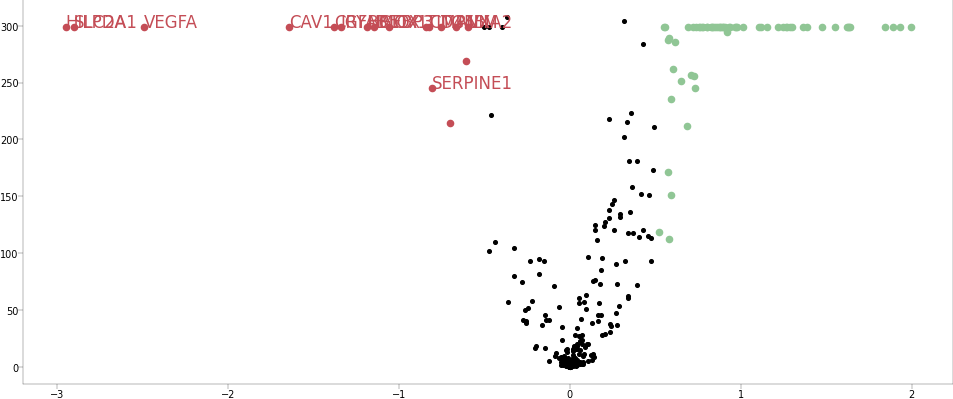

In [36]:
pos_df, neg_df = plot_volcano(
    test_hyp_vs_pla,
    fc_pos=.5,
    fc_neg=-.5,
    max_qval=1,
    qval_filter=-1,
    neg_color='#c44d56',
    pos_color='#90c695',
    filename='Hypoxia_vs_Plasma',
    highlight_genes = [
        #Hypoxia
        'ANXA2','APP','CAV1','CD44','CRYAB','HILPDA','HMOX1','IGFBP3','IGFBP5','LOX','SERPINE1','SLC2A1','SPARC','TGFBI','TIMP1','VEGFA','VIM',
        #Plasma
        #'AQP4','EDNRB','GFAP','IDH1','IDH2','KIT','MKI67','OLIG1','PAX6','PDGHRA','TTYH1', 'PCNA','PLAU','SERPINA3', 'NES', 'NOTCH1','TOP2A','TNC',
        'SPP1','CD274'

                      ],
    figsize=(12,5),
)
gene_hyp = neg_df.gene.tolist()
gene_pla = pos_df.gene.tolist()

In [26]:
gene_hyp

['ANXA2',
 'CAV1',
 'CD44',
 'CRYAB',
 'EPAS1',
 'HILPDA',
 'HMOX1',
 'IGFBP3',
 'IGFBP5',
 'LOX',
 'NTNG2',
 'SERPINE1',
 'SLC2A1',
 'TGFBI',
 'TIMP1',
 'VEGFA',
 'VIM']

In [ ]:
genes_expressed_hypoxia_alone = [g for g in neg_df.gene if g not in gene_hyp]

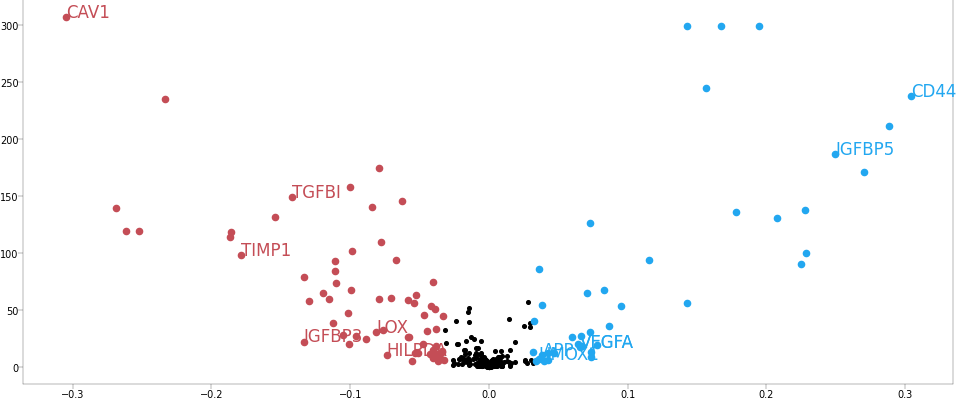

In [39]:
pos_df, neg_df = plot_volcano(
    test_hyp_vs_hyppla,
    fc_pos=.032,
    fc_neg=-.032,
    max_qval=1,
    qval_filter=-1,
    neg_color='#c44d56',
    pos_color='#22a7f0',
    filename='Hypoxia_vs_HypoxiaPlasma',
    highlight_genes = [
        #Hypoxia
        #'ANXA1','ANXA2','APP','CD44','CD74','CHI3L1','CNTNAP3B','DNER','GJA1', 'HES1', 'IGFBP5','ISG15','MT1X', 'MT2A','NNAT','PLAU', 'SERPINA3','SPON1','SPP1','SULF1',   
        
        'APP','CAV1','CD44','CRYAB','HILPDA','HMOX1','IGFBP3','IGFBP5','LOX','SERPINE1','SLC2A1','SPARC','TGFBI','TIMP1','VEGFA','VIM',
        'VEGFA'
        ],
    figsize=(12,5),
)

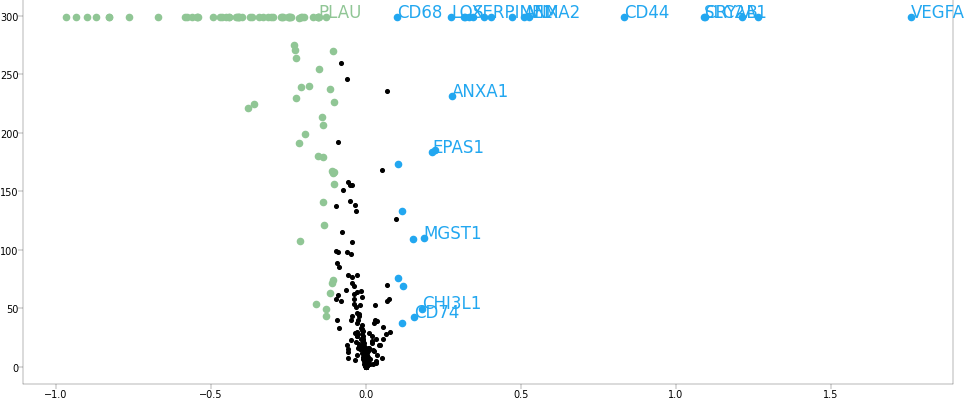

In [33]:
pos_df, neg_df = plot_volcano(
    test_pla_vs_hyppla,
    fc_pos=.1,
    fc_neg=-.1,
    max_qval=1,
    qval_filter=-1,
    neg_color='#90c695',
    pos_color='#22a7f0',
    filename='Plasma_vs_HypoxiaPlasma',
    highlight_genes = [
        #Hypoxia
        'ANXA1','ANXA2','CD44','CD68','CD74','CHI3L1','CRYAB','EPAS1', 'LGALS1','LOX', 'MGST1','PLAU','SERPINE1','SERPINA3','SLC2A1','VEGFA','VIM',

        ],
    figsize=(12,5),
)

In [182]:
genes_pla = [g for g in neg_df.gene if g not in gene_pla]

In [183]:
genes_pla

['ADAMTS3',
 'BCAN',
 'CDK4',
 'CEMIP2',
 'CENPF',
 'DLL3',
 'EDNRB',
 'EGFR',
 'ERBB3',
 'FGFR2',
 'FOXG1',
 'HES6',
 'HIF1A',
 'HIST1H1D',
 'IDH1',
 'IDH2',
 'KIT',
 'NES',
 'NOTCH1',
 'OLIG2',
 'PAX6',
 'PCNA',
 'PDGFRA',
 'PTPRZ1',
 'S100B',
 'SLC1A3',
 'SOX10',
 'SOX2',
 'SOX4',
 'STMN1',
 'TENM1',
 'TNC',
 'TOP2A',
 'VCAN']